## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History
from tensorflow.keras import optimizers


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3460,2022-12-13 00:00:00-03:00,102.260002,103.730003,100.019997,100.300003,16354218,0,0
3461,2022-12-14 00:00:00-03:00,99.300003,101.160004,98.300003,100.699997,15092220,0,0
3462,2022-12-15 00:00:00-03:00,99.940002,102.199997,99.550003,100.500000,12770355,0,0
3463,2022-12-16 00:00:00-03:00,100.449997,100.639999,98.809998,99.400002,12353740,0,0


In [4]:
len(bova11)

3465

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3367,2022-12-13 00:00:00-03:00,102.260002,103.730003,100.019997,100.300003,16354218,0,0
3368,2022-12-14 00:00:00-03:00,99.300003,101.160004,98.300003,100.699997,15092220,0,0
3369,2022-12-15 00:00:00-03:00,99.940002,102.199997,99.550003,100.500000,12770355,0,0
3370,2022-12-16 00:00:00-03:00,100.449997,100.639999,98.809998,99.400002,12353740,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3372/3372 [00:00<00:00, 16666.27it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

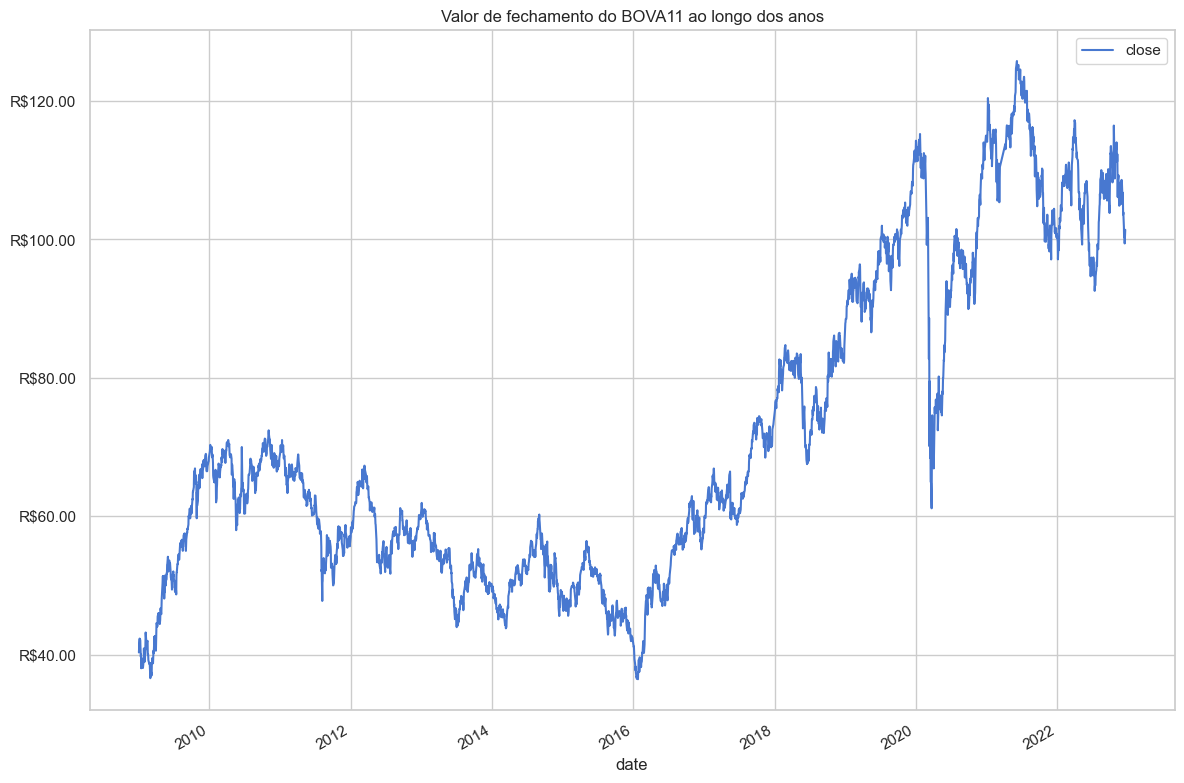

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

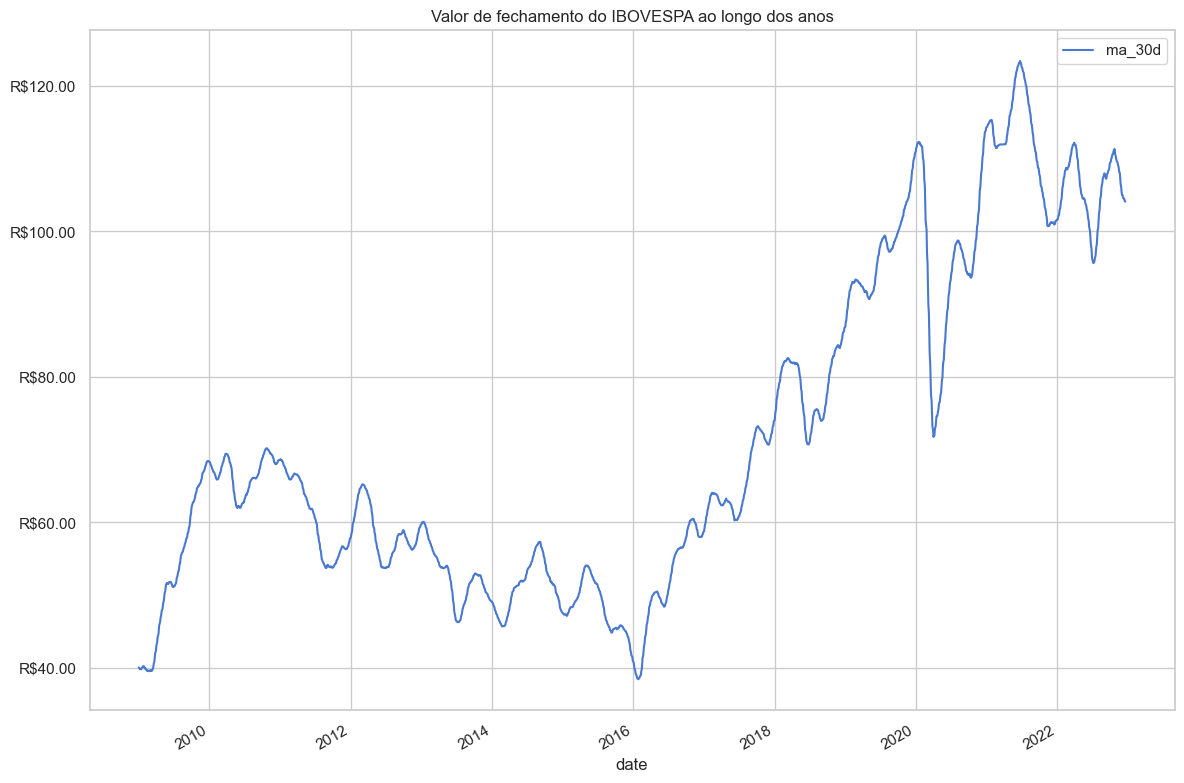

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,102.260002,103.730003,100.019997,100.300003,-1.500000,100.933334,102.387000,104.455500,106.685429,1.713152,2.884087,3.971789,102.486827,99.379842,110.223673,98.687326,114.629006,98.741851,35.651080
3368,99.300003,101.160004,98.300003,100.699997,0.399994,100.500000,101.903334,104.423158,106.499706,1.440052,2.959389,3.874184,100.899994,100.100006,110.341935,98.504380,114.248074,98.751337,36.839277
3369,99.940002,102.199997,99.550003,100.500000,-0.199997,100.199999,101.442501,104.377778,106.328485,0.842151,3.038376,3.801372,101.599996,98.800003,110.454530,98.301025,113.931229,98.725741,36.478435
3370,100.449997,100.639999,98.809998,99.400002,-1.099998,100.423335,101.138573,104.152941,106.125937,0.713498,2.973536,3.676828,102.397806,98.448863,110.100013,98.205869,113.479593,98.772282,34.487751


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,102.260002,103.730003,100.019997,100.300003,-1.500000,100.933334,102.387000,104.455500,106.685429,1.713152,...,3.971789,102.486827,99.379842,110.223673,98.687326,114.629006,98.741851,35.651080,-1.959999,100.699997
3368,99.300003,101.160004,98.300003,100.699997,0.399994,100.500000,101.903334,104.423158,106.499706,1.440052,...,3.874184,100.899994,100.100006,110.341935,98.504380,114.248074,98.751337,36.839277,1.399994,100.500000
3369,99.940002,102.199997,99.550003,100.500000,-0.199997,100.199999,101.442501,104.377778,106.328485,0.842151,...,3.801372,101.599996,98.800003,110.454530,98.301025,113.931229,98.725741,36.478435,0.559998,99.400002
3370,100.449997,100.639999,98.809998,99.400002,-1.099998,100.423335,101.138573,104.152941,106.125937,0.713498,...,3.676828,102.397806,98.448863,110.100013,98.205869,113.479593,98.772282,34.487751,-1.049995,101.370003


In [24]:
bova11.dropna(inplace = True)

In [25]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.58158801  0.44068748  0.40638354 ... -0.34808104 -0.80353922
   0.43449048]
 [ 0.59178152  0.46389903  0.43447974 ... -0.358919   -0.82694723
   0.40985445]
 [ 0.59990439  0.42908154  0.41784667 ... -0.41870962 -0.87181257
   0.45397542]]


Select the features and prediction target columns

In [26]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3256, 100, 19), (3256, 1))

Split the train and test data

In [27]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 4. Creating the model

In [28]:
def create_lstm_model(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(150, input_shape = (backcandles, num_features), return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(80, return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(1, return_sequences = False))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam())
    return model

In [29]:
#model = create_lstm_model(100, 19, 0.2)
#model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 30, shuffle = True, validation_split = 0.1)

### 5. Making predictions

In [30]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

NameError: name 'model' is not defined

In [ ]:
y_pred.shape

In [ ]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [ ]:
len(y_test)

In [ ]:
# removing last prediction, (nan values to calculate the right metrics)
y_test = y_test[:-2]
#y_pred = y_pred[:-2]

In [34]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [ ]:
MAPE(y_test, y_pred)

In [ ]:
MAE(y_test, y_pred)

In [ ]:
RMSE(y_test, y_pred)

As we can see, the model with multiple layers seems to permorme worse than the single layer one. We can do some tests decreasing the epochs so the model runs fasters and try diferent combinations of layers.

### Testing different model architectures 

In [56]:
def create_lstm_model_1(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(150, input_shape = (backcandles, num_features), return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(80, return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(1, return_sequences = False))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam())
    return model

def create_lstm_model_2(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(150, input_shape = (backcandles, num_features), return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(1, return_sequences = False))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam())
    return model


def create_lstm_model_3(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(150, input_shape = (backcandles, num_features), return_sequences = True))
    model.add(Dropout(dropout_prob))
    
    model.add(LSTM(1, return_sequences = False))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam())
    return model

def create_lstm_model_4(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(150, input_shape = (backcandles, num_features)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [33]:
model_1 = create_lstm_model_1(100, 19, 0.2)
model_1.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_1 = model_1.predict(X_test)



Epoch 1/5
176/176 [==============================] - 43s 204ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 2/5
176/176 [==============================] - 36s 206ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 3/5
176/176 [==============================] - 37s 210ms/step - loss: 0.0024 - val_loss: 0.0068
Epoch 4/5
176/176 [==============================] - 35s 200ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 5/5
11/11 [==============================] - 3s 81ms/step


NameError: name 'MAPE' is not defined

In [35]:
print(MAPE(y_test, y_pred_1))
print(MAE(y_test, y_pred_1))
print(RMSE(y_test, y_pred_1))

10.10755261050427
0.05174473451294996
0.0625355323281432


In [36]:
model_2 = create_lstm_model_2(100, 19, 0.2)
model_2.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_2 = model_2.predict(X_test)

print(MAPE(y_test, y_pred_2))
print(MAE(y_test, y_pred_2))
print(RMSE(y_test, y_pred_2))

Epoch 1/5
176/176 [==============================] - 37s 170ms/step - loss: 0.0104 - val_loss: 0.0042
Epoch 2/5
176/176 [==============================] - 28s 159ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 3/5
176/176 [==============================] - 29s 162ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 4/5
176/176 [==============================] - 28s 161ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 5/5
11/11 [==============================] - 2s 73ms/step
14.216946959494633
0.07130333746939542
0.08582400644463613


In [37]:
model_2 = create_lstm_model_2(100, 19, 0.2)
model_2.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_2 = model_2.predict(X_test)

print(MAPE(y_test, y_pred_2))
print(MAE(y_test, y_pred_2))
print(RMSE(y_test, y_pred_2))

Epoch 1/5
176/176 [==============================] - 35s 165ms/step - loss: 0.0121 - val_loss: 0.0058
Epoch 2/5
176/176 [==============================] - 27s 154ms/step - loss: 0.0026 - val_loss: 0.0067
Epoch 3/5
176/176 [==============================] - 28s 157ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 4/5
176/176 [==============================] - 28s 158ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 5/5
11/11 [==============================] - 2s 69ms/step
13.579813007503017
0.06629568174905678
0.08240351192139449


In [38]:
model_3 = create_lstm_model_3(100, 19, 0.2)
model_3.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_3 = model_3.predict(X_test)

print(MAPE(y_test, y_pred_3))
print(MAE(y_test, y_pred_3))
print(RMSE(y_test, y_pred_3))

Epoch 1/5
176/176 [==============================] - 26s 126ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 2/5
176/176 [==============================] - 22s 126ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 3/5
176/176 [==============================] - 22s 126ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 4/5
176/176 [==============================] - 23s 131ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 5/5
11/11 [==============================] - 1s 52ms/step
7.963358593130884
0.0418590279860781
0.05093620543453219


In [57]:
model_4 = create_lstm_model_4(100, 19, 0.2)
model_4.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_4 = model_4.predict(X_test)

print(MAPE(y_test, y_pred_4))
print(MAE(y_test, y_pred_4))
print(RMSE(y_test, y_pred_4))

Epoch 1/5
176/176 [==============================] - 19s 92ms/step - loss: 0.0095 - val_loss: 0.0016
Epoch 2/5
176/176 [==============================] - 15s 84ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 3/5
176/176 [==============================] - 15s 87ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/5
176/176 [==============================] - 16s 88ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/5
11/11 [==============================] - 1s 51ms/step
6.800779349914227
0.03453354246821435
0.04192332996147711


Testing diferent layers to build the network, seems like for this problem a single layer network works better, we can run the RandomSearch() to see wich are the best hiperparameters for the network

In [58]:
def create_lstm_model(backcandles, num_features):
    lstm_input = Input(shape = (backcandles, num_features), name = 'lstm_input')
    inputs = LSTM(150, name = 'first_layer')(lstm_input)
    inputs = Dense(1, name = 'dense_layer')(inputs)
    output = Activation('linear', name = 'output')(inputs)
    model = Model(inputs = lstm_input, outputs = output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [ ]:
model_5 = create_lstm_model(100, 19)
model_5.fit(x = X_train, y = y_train, batch_size = 15, epochs = 5, shuffle = True, validation_split = 0.1)

y_pred_5 = model_5.predict(X_test)

print(MAPE(y_test, y_pred_5))
print(MAE(y_test, y_pred_5))
print(RMSE(y_test, y_pred_5))

Epoch 1/5
176/176 [==============================] - 17s 87ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 2/5
176/176 [==============================] - 14s 82ms/step - loss: 9.1784e-04 - val_loss: 0.0019
Epoch 3/5
176/176 [==============================] - 16s 88ms/step - loss: 9.4872e-04 - val_loss: 0.0014
Epoch 4/5
 73/176 [===========>..................] - ETA: 8s - loss: 7.5532e-04